# Validation of the Gamma distribution
Validate that generated data comes from the Gamma distribution.

1. Generate gamma distribution dataset and obtain original coefficients on which the normal distribution was built.
2. Check that the generated dataset has these coefficients close enough to the original ones.

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as tt

from app import Generator

In [5]:
g = Generator(n_rows=2500,
     n_columns=200,
     informative_ratio=0.75,
     distribution='gamma',
)

df = g.generate_data()

# PyMC Gamma
Use the PyMC module to obtain the original coefficients.

In [6]:
model = pm.Model()

X = df.drop(columns=['y', 'y_exact'])
y = df['y']

with model:
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    coefficients = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1])

    sigma = pm.HalfNormal('sigma', sigma=10)  # prior pro standardní odchylku

    # Lineární kombinace vlastností a koeficientů
    eta = intercept + tt.dot(X, coefficients)
    mu = eta
    
    # Výpočet parametrů gamma rozdělení
    alpha = (mu ** 2) / (sigma ** 2)
    beta = abs(mu) / (sigma ** 2)
    
    # Likelihood (pozorovaná data)
    y_obs = pm.Gamma('y_obs', alpha=alpha, beta=beta, observed=y)
    
    # Vzorkování z posterioru
    trace = pm.sample(200, tune=1000, target_accept=0.95, init='jitter+adapt_diag')

coefficients_summary = pm.summary(trace)['mean']
print(coefficients_summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta, sigma]


Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 4028 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Intercept     -0.955
beta[0]       -0.187
beta[1]        0.443
beta[2]        0.940
beta[3]       -0.874
              ...   
beta[196]     -0.365
beta[197]     -1.234
beta[198]     -0.732
beta[199]     -1.126
sigma        118.955
Name: mean, Length: 202, dtype: float64


## Comparison
Compare the original coefficients with the coefficients obtained with PyMC.

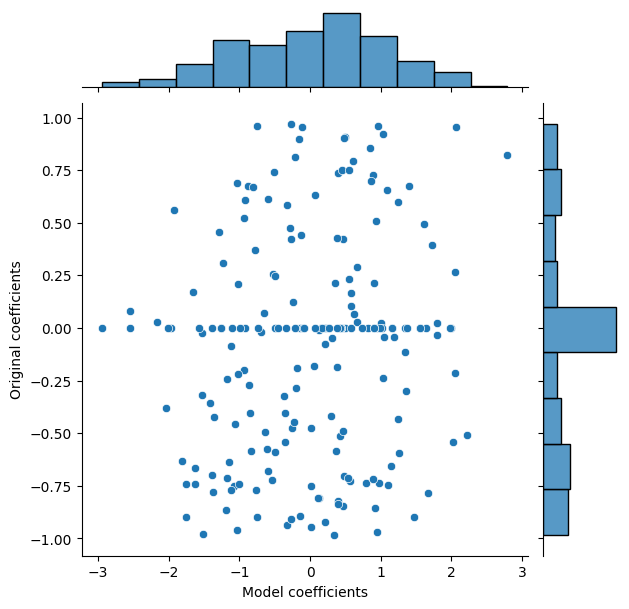

In [8]:
sns.jointplot(x=coefficients_summary.iloc[1:-1].tolist(), y=g.coef_)
plt.xlabel('Model coefficients')
plt.ylabel('Original coefficients')
plt.show()

As may be seen, PyMC was not successful and there is some problem with the data generation.